# Evaluation

,model,sharded_N,sharded_score,full_N,full_score,concat_N,concat_score
0,exp_20250530_1/model/,1070,56.64,1070,88.69,1070,84.95
1,exp_20250605_2_gpu3/best_model,1020,46.76,1020,89.12,1020,84.90
2,gs-microsoft/phi-4,1070,36.54,1070,88.41,1070,81.31
3,exp_20250605_2/best_model,1020,48.14,1020,89.31,1020,85.69
4,exp_20250524_1/phi-4-mtco-singles/,1070,47.10,1070,89.91,1070,85.98
5,t-phi-4,1376,38.08,1070,88.41,1070,83.08
6,exp_20250524_4/phi4-mtco-db-1ep/,1070,69.91,1070,89.72,1070,83.64


,model,n_samples,num_runs,averaged_perf,median,best-aptitude (P_90),worst-aptitude (P_10),U75-25,U90-10
0,exp_20250524_4/phi4-mtco-db-1ep/,1070,10.00,69.91,74.77,93.93,42.90,28.97,51.03
1,exp_20250530_1/model/,1070,10.00,56.64,56.54,81.21,28.88,26.40,52.34
2,exp_20250605_2/best_model,1020,9.53,48.14,49.02,75.29,22.55,32.60,52.75
3,exp_20250524_1/phi-4-mtco-singles/,1070,10.00,47.10,44.86,71.31,24.86,24.07,46.45
4,exp_20250605_2_gpu3/best_model,1020,9.53,46.76,44.12,74.61,22.65,29.66,51.96
5,t-phi-4,1376,12.86,38.12,35.51,59.25,16.26,25.93,42.99
6,gs-microsoft/phi-4,1070,10.00,36.54,33.64,60.09,16.92,26.87,43.18


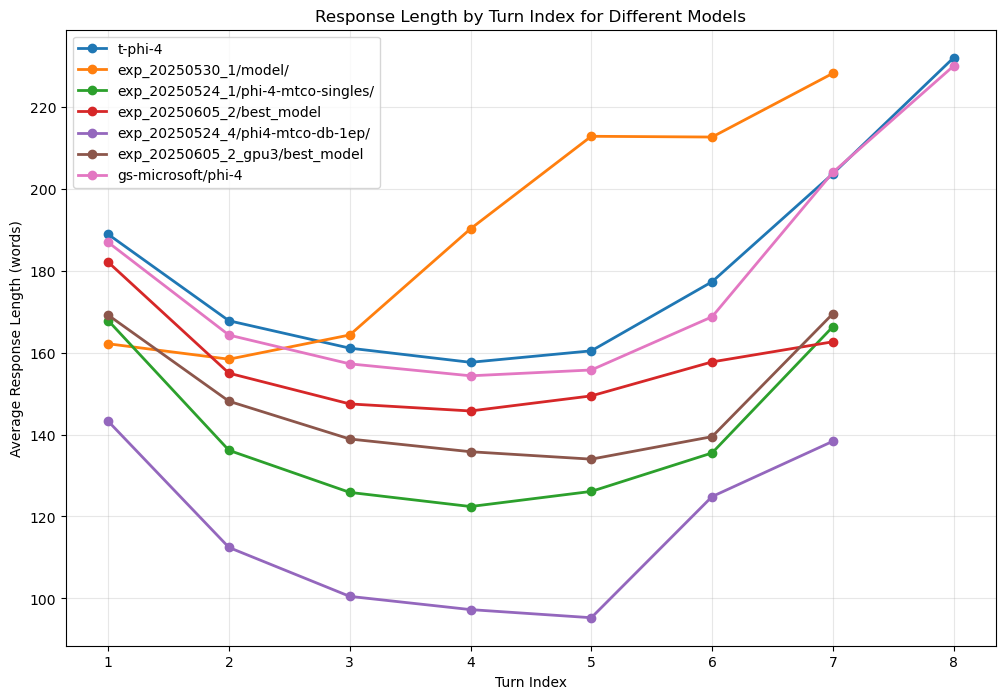

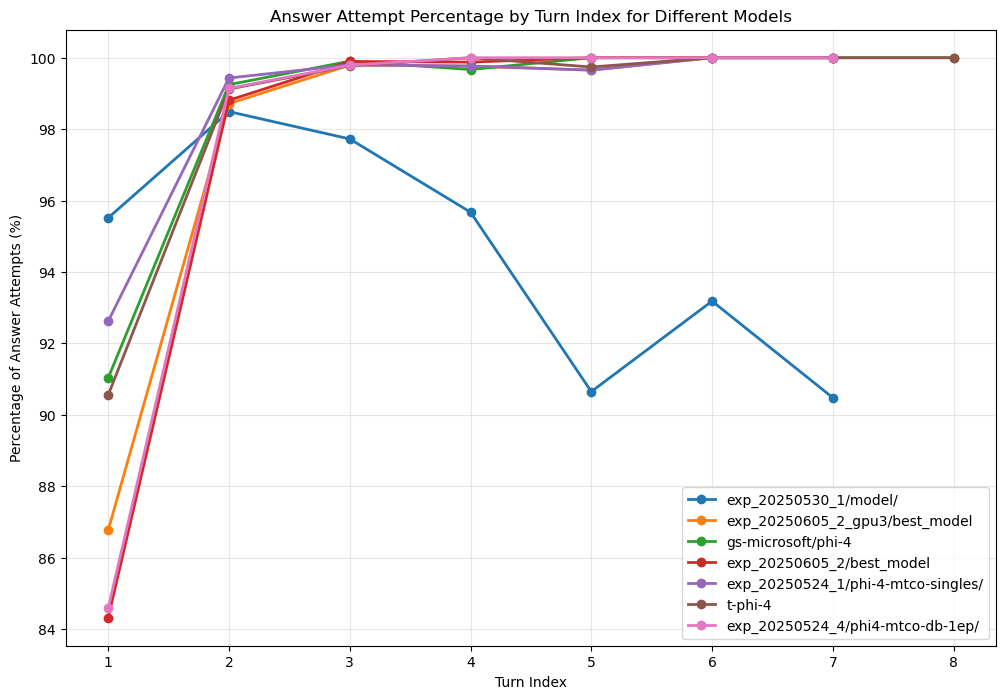

In [2]:
import os, json, numpy as np, pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display
from collections import Counter

task = "database"

# folder = f"logs/{task}/sharded"
task_types = ["sharded", "full", "concat"]
results, response_lengths, strat_distribution = {}, {}, {}
models = set()
for task_type in task_types:
    folder = f"logs/{task}/{task_type}"
    results[task_type] = {}
    for fn in os.listdir(folder):
        logs = []
        with open(os.path.join(folder, fn), "r") as f:
            for line in f:
                logs.append(line)
        for line in logs:
            log = json.loads(line)
            model = log["assistant_model"].replace("gs-experiments/", "")
            models.add(model)
            score = log["score"]
            if score is None:
                continue # This should not be needed, but somehow it is...
            task_id = log["task_id"]
            if task_id not in results[task_type]:
                results[task_type][task_id] = {}
            if model not in results[task_type][task_id]:
                results[task_type][task_id][model] = []
            results[task_type][task_id][model].append(score)

            if task_type != "sharded":
                continue
            if model not in response_lengths:
                response_lengths[model] = {}
                strat_distribution[model] = {}
            for depth, msg in enumerate(log["trace"]):
                if msg["role"] == "assistant":
                    turn_idx = (depth) / 2
                    num_words = len(msg["content"].split())
                    if turn_idx not in response_lengths[model]:
                        response_lengths[model][turn_idx] = []
                        strat_distribution[model][turn_idx] = []
                    response_lengths[model][turn_idx].append(num_words)
                    strat_distribution[model][turn_idx].append(msg["response_strategy"])

models = list(models)
task_ids = list(results["sharded"].keys())

conv_type_results = []
for model in models:
    row = {"model": model}

    for task_type in task_types:
        scores = []
        for task_id in task_ids:
            scores += results.get(task_type, {}).get(task_id, {}).get(model, [])
        if len(scores) > 0:
            row[f"{task_type}_N"] = len(scores)
            if len(scores) > 0:
                row[f"{task_type}_score"] = 100.0 * np.mean(scores)
    conv_type_results.append(row)

display(pd.DataFrame(conv_type_results).round(2))

condensed_results = []
for model in models:
    row = {"model": model}
    n_samples, averaged_perfs, medians, aptitudes = [], [], [], []
    U7525s, U9010s, P_10s = [], [], []
    for task_id in task_ids:
        n_samples.append(len(results["sharded"][task_id].get(model, [])))
        if len(results["sharded"][task_id].get(model, [])) == 0:
            continue
        averaged_perf = np.mean(results["sharded"][task_id][model])
        aptitude = np.percentile(results["sharded"][task_id][model], 90)
        P_10 = np.percentile(results["sharded"][task_id][model], 10)
        U7525 = np.percentile(results["sharded"][task_id][model], 75) - np.percentile(results["sharded"][task_id][model], 25)
        U9010 = np.percentile(results["sharded"][task_id][model], 90) - np.percentile(results["sharded"][task_id][model], 10)
        medians.append(np.median(results["sharded"][task_id][model]))
        averaged_perfs.append(averaged_perf)
        aptitudes.append(aptitude)
        U7525s.append(U7525)
        U9010s.append(U9010)
        P_10s.append(P_10)
    row["n_samples"] = np.sum(n_samples)
    row["num_runs"] = row["n_samples"] / len(task_ids)
    row["averaged_perf"] = 100.0 * np.mean(averaged_perfs)
    row["median"] = 100.0 * np.mean(medians)
    row["best-aptitude (P_90)"] = 100.0 * np.mean(aptitudes)
    row["worst-aptitude (P_10)"] = 100.0 * np.mean(P_10s)
    row["U75-25"] = 100.0 * np.mean(U7525s)
    row["U90-10"] = 100.0 * np.mean(U9010s)

    condensed_results.append(row)

condensed_results = sorted(condensed_results, key=lambda x: x["averaged_perf"], reverse=True)
condensed_results = pd.DataFrame(condensed_results)

display(condensed_results.style.format(precision=2))

plt.figure(figsize=(12, 8))
for model in response_lengths:
    turn_indices = sorted(response_lengths[model].keys())
    avg_lengths = []
    
    for turn_idx in turn_indices:
        avg_length = np.mean(response_lengths[model][turn_idx])
        avg_lengths.append(avg_length)
    
    plt.plot(turn_indices, avg_lengths, marker='o', label=model, linewidth=2)

plt.xlabel('Turn Index')
plt.ylabel('Average Response Length (words)')
plt.title('Response Length by Turn Index for Different Models')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


plt.figure(figsize=(12, 8))
for model in models:
    turn_indices = sorted(strat_distribution[model].keys())
    perc_answer_attempts = []
    
    for turn_idx in turn_indices:
        counts = Counter(strat_distribution[model][turn_idx])
        perc_answer_attempt = 100.0 * counts["answer_attempt"] / sum(counts.values())
        perc_answer_attempts.append(perc_answer_attempt)
    
    plt.plot(turn_indices, perc_answer_attempts, marker='o', label=model, linewidth=2)

plt.xlabel('Turn Index')
plt.ylabel('Percentage of Answer Attempts (%)')
plt.title('Answer Attempt Percentage by Turn Index for Different Models')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [3]:
# Multi-task analysis for database, actions, and math
tasks = ["database", "actions", "math"]
task_types = ["concat", "full", "sharded"]

# Collect results for all tasks
all_task_results = {}
all_models = set()

for task in tasks:
    all_task_results[task] = {}
    for task_type in task_types:
        folder = f"logs/{task}/{task_type}"
        all_task_results[task][task_type] = {}
        
        if not os.path.exists(folder):
            print(f"Warning: Folder {folder} does not exist, skipping...")
            continue
            
        for fn in os.listdir(folder):
            logs = []
            with open(os.path.join(folder, fn), "r") as f:
                for line in f:
                    logs.append(line)
            for line in logs:
                try:
                    log = json.loads(line)
                    model = log["assistant_model"].replace("gs-experiments/", "")
                    all_models.add(model)
                    score = log["score"]
                    if score is None:
                        continue
                    task_id = log["task_id"]
                    if task_id not in all_task_results[task][task_type]:
                        all_task_results[task][task_type][task_id] = {}
                    if model not in all_task_results[task][task_type][task_id]:
                        all_task_results[task][task_type][task_id][model] = []
                    all_task_results[task][task_type][task_id][model].append(score)
                except json.JSONDecodeError:
                    continue

all_models = list(all_models)

# Create consolidated table
consolidated_table = []
for model in all_models:
    row = {"model": model}
    
    for task in tasks:
        for task_type in task_types:
            scores = []
            # Collect all scores for this model, task, and task_type
            for task_id in all_task_results[task].get(task_type, {}):
                scores += all_task_results[task][task_type][task_id].get(model, [])
            
            # Calculate average performance
            if len(scores) > 0:
                avg_score = 100.0 * np.mean(scores)
                row[f"{task}_{task_type}"] = avg_score
            else:
                row[f"{task}_{task_type}"] = None
    
    consolidated_table.append(row)

# Sort by overall performance (average across all task-type combinations)
for row in consolidated_table:
    scores = []
    for task in tasks:
        for task_type in task_types:
            if row[f"{task}_{task_type}"] is not None:
                scores.append(row[f"{task}_{task_type}"])
    row["overall_avg"] = np.mean(scores) if scores else 0

consolidated_table = sorted(consolidated_table, key=lambda x: x["overall_avg"], reverse=True)

# Create DataFrame with MultiIndex columns for double headers
consolidated_df = pd.DataFrame(consolidated_table)

# Create the multi-level column structure
columns = [("", "model")]  # First column for model names
for task in tasks:
    for task_type in task_types:
        columns.append((task, task_type))

# Prepare data for MultiIndex DataFrame
data_for_multiindex = []
for row in consolidated_table:
    row_data = [row["model"]]
    for task in tasks:
        for task_type in task_types:
            row_data.append(row[f"{task}_{task_type}"])
    data_for_multiindex.append(row_data)

# Create MultiIndex columns
multi_columns = pd.MultiIndex.from_tuples(columns)

# Create DataFrame with MultiIndex columns
consolidated_df_display = pd.DataFrame(data_for_multiindex, columns=multi_columns)

print("Consolidated Performance Table")
print("="*50)

# Style the table to center the first header row
styled_df = consolidated_df_display.style.set_table_styles([
    {'selector': 'th.col_heading.level0', 
     'props': [('text-align', 'center')]},
    {'selector': 'th.col_heading.level1', 
     'props': [('text-align', 'center')]}
]).format(precision=2)
display(styled_df)

Consolidated Performance Table
